# Word embeddings
Machines, especially machine learning models operate on numeric data, posing a challenge for understanding human language. Therefore, it would be nice to have a method to convert textual data into numeric data. Also, it would be useful to have a method to determine whether two texts are similar or not. A lot of search tasks like question answering or recommendation systems are based on that problem.

Before we start, we import all packages that we need in this notebook.

In [1]:
from itertools import combinations

import random

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

Imagine we have a solution to these problems, i.e. we know how to measure the semantic similarity between two strings. Then we can use the **$k$-nearest-neighbour** search to find the $k$-most similar texts from a dataset.

We solve this problems with so called **word embeddings**. These are techniques to transform words into dense vectors, capturing semantic relationships in a high-dimensional space. The idea is to find a vector for each word so that similar words are close to each other and dissimilar words are far away.

Before we start exploring the different methods of creating word embeddings, we begin with analyzing how to measure similarity.

## Similarity Search
Measuring the similarity of objects is depending on the context of the task. Consider the three points $x=(1, 1, 1), y=(1, 0, 1), z=(100, 100, 100)$. Then using the euclidean distance the points $x$ and $y$ are close to each other and $z$ is far away. But imagine that the vectors are representations of purchases in a retail store, e.g. the first dimension represents apples, the second bananas and the third dimension represents coconuts. Then one could argue that $x$ and $z$ are more closely because $z$ is a multiple of $x$. In other words, the person with purchase $z$ just did purchase $x$ 100 times. This leads to the definition of the cosine similarity.

### Cosine Similarity
The **cosine similarity** $S_c\colon\mathbb{R}^d\backslash\{0\}\times\mathbb{R}^d\backslash\{0\}\to [-1, 1]$ is defined as
$$
    S_c(v, w) = \cos\angle(v, w) = \frac{\langle v, w\rangle}{\left\lVert v\right\rVert\cdot \left\lVert w\right\rVert}.
$$
for $v, w\in\mathbb{R}^d\backslash\{0\}$. Since the cosine similarity only measures the angle between the vectors, the cosine similarity is independent of scaling. In fact, let $\lambda, \mu > 0$. Then it holds
$$
    S_c(\lambda v, \mu w) = \frac{\langle \lambda v, \mu w\rangle}{\left\lVert\lambda v\right\rVert\cdot\left\lVert\mu w\right\rVert} = \frac{\lambda\mu\langle v, w\rangle}{\lambda\mu\left\lVert v\right\rVert\cdot \left\lVert w\right\rVert} = \frac{\langle v, w\rangle}{\left\lVert v\right\rVert\cdot \left\lVert w\right\rVert} = S_c(v, w).
$$
Similarly, this also holds for $\lambda, \mu < 0$. Using $\lambda = \left\lVert v\right\rVert$ and $\mu = \left\lVert w\right\rVert$ we see that without loss of generality we can assume that $v$ and $w$ are unit vectors. For unit vectors the formula simplifies to $S_c(v, w) = \langle v, w\rangle$.

Further, cosine similarity is related to the euclidean distance. In fact, the dot product induces the euclidean norm, i.e. for $v\in\mathbb{R}^d$ it holds $\langle v, v\rangle = \left\lVert v\right\rVert^2$. Therefore, for unit vectors $v, w\in\mathbb{R}^d$ we see that
$$
    \left\lVert v - w\right\rVert^2 = \langle v - w, v - w\rangle = \left\lVert v\right\rVert^2 + \left\lVert w\right\rVert^2 - 2\langle v, w\rangle = 2 - 2S_c(v, w) = 2(1 - S_c(v, w)).
$$
Hence, minimizing the euclidean distance of $v$ and $w$ is the same as maximizing the cosine similarity of $v$ and $w$. The value $D_c(v, w) = 1 - S_c(v, w)$ is also called **cosine distance** although it is not a metric.

Next, we implement the cosine similarity using pytorch.

In [2]:
def cosine_similarity(v: torch.tensor, w: torch.tensor) -> float:
    sim = torch.dot(v, w) / (torch.norm(v) * torch.norm(w))
    return sim.item()

## Approaches
There are several ways to create word embeddings. The most easy ones are **one-hot encoding** and **bag of words**.
### One-Hot Encoding
An easy way to create word embeddings is to use an one-hot encoding, i.e. representing each word with a vector for which only one entry is 1 and all other entries are 0. For example, consider the sentence "the quick brown fox jumps over the lazy dog". Then the vocabulary would be (the, quick, borwn, fox, jumps, over, lazy, dog) and we can visualize the one-hot encoding as follows:

    the   : [1, 0, 0, 0, 0, 0, 0, 0]
    quick : [0, 1, 0, 0, 0, 0, 0, 0]
    brown : [0, 0, 1, 0, 0, 0, 0, 0]
    fox   : [0, 0, 0, 1, 0, 0, 0, 0]
    jumps : [0, 0, 0, 0, 1, 0, 0, 0]
    over  : [0, 0, 0, 0, 0, 1, 0, 0]
    lazy  : [0, 0, 0, 0, 0, 0, 1, 0]
    dog   : [0, 0, 0, 0, 0, 0, 0, 1]

To create vector representations of complete sentences we can concatenate this one-hot encoded vectors.

This approach has a big problem: it creates sparse vectors. In other words, most entries of the vector are $0$ and hence don't save any information about the text the vector represents.

### Bag of words
An alternative approach is to encode each word with a unique number, e.g. if we are using the example from above we assign 1 to "the", 2 to "quick" and so on. The encoding of "the quick brown fox jumps over the lazy dog" is then $(1, 2, 3, 4, 5, 6, 1, 7, 8)$. This is called **bag of words**.

We clearly see that this approach does not suffer on sparsity. But here we have another problem: the integer-encoding is arbitrary. It does not capture any relationship between words. For example he difference between "the" and "quick" is 1, the difference between "the" and "lazy" is 6, but in both cases the text is not really similar.

### n-gram model
For a sequence of words $w$, an $n$-gram language model computes the probability
$$
    P(w_i\vert w_{i - 1}, w_{i - 2}, \dotsc, w_{i - n}),
$$
i.e. the probability that the word $w_i$ occurs given that the previous words are $w_{i - n},\dotsc, w_{i - 2}, w_{i - 1}$. The subsequence $w_{i - n},\dotsc, w_{i - 2}, w_{i - 1}$ is called **$n$-gram**. For example, for the sentence "the quick brown fox jumps over the lazy dog" we get the following $5$-grams:
- (the, quick, brown, fox, jumps)
- (quick, brown, fox, jumps, over)
- (brown, fox, jumps, over, the)
- (fox, jumps, over, the, lazy)
- (jumps, over, the, lazy, dog)

Before we start implementing the $n$-gram language model, we define a text as training data set. This text will also be used for the other models.

In [3]:
text = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold."""

First, we need to get all $n$-grams from the text. For this, we need to define the number of considered words, which we now denote with CONTEXT_SIZE instead of $n$.

In [4]:
splitted_text = text.split()

CONTEXT_SIZE = 10

ngrams = [
    (
        [splitted_text[i - CONTEXT_SIZE + j] for j in range(CONTEXT_SIZE)],
        splitted_text[i]
    )
    for i in range(CONTEXT_SIZE, len(splitted_text))
]

vocab = set(splitted_text)
word_to_idx = {word: idx for idx, word in enumerate(vocab)}

Since neural networks work with numerical input we define a function, which transforms an $n$-gram to a tensor.

In [5]:
def text_to_tensor(text: list[str]) -> torch.tensor:
    return torch.tensor([word_to_idx[word] for word in text], dtype=torch.long)

For the language model we use a neural network consisting of an embedding layer and two linear layers. As activation function we use the ReLU activation function.

In [6]:
class NGramLanguageModeler(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, context_size: int) -> None:
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs: torch.tensor) -> torch.tensor:
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

    def get_word_embedding(self, word: str) -> torch.tensor:
        input = text_to_tensor([word])
        return self.embeddings(input).squeeze()

In [7]:
EMBEDDING_DIM = 10
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)

In [8]:
LEARNING_RATE = 0.001
EPOCHS = 50

losses: list[float] = []
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [9]:
for epoch in range(EPOCHS):
    total_loss = 0
    for context, target in ngrams:
        context_ids = text_to_tensor(context)

        model.zero_grad()

        log_probs = model(context_ids)

        loss = loss_function(log_probs, text_to_tensor([target]))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    losses.append(total_loss)

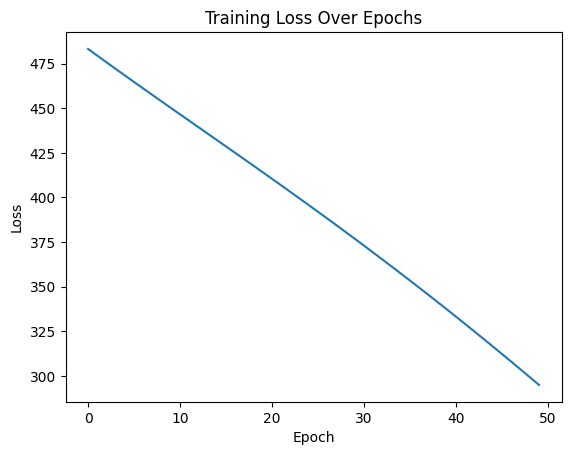

In [10]:
plt.plot(losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [11]:
def compare_word_embeddings(model, texts: list[str]) -> None:
    embeddings = [
        {
            "text": text,
            "embedding": model.get_word_embedding(text)
        }
        for text in texts
    ]

    pairs = list(combinations(embeddings, 2))
    
    for (entry_left, entry_right) in pairs:
        print(f"Cosine similarity of '{entry_left['text']}' and '{entry_right['text']}': {cosine_similarity(entry_left['embedding'], entry_right['embedding'])}")

In [12]:
compare_word_embeddings(model, ["beauty", "warm", "cold."])

Cosine similarity of 'beauty' and 'warm': -0.21811164915561676
Cosine similarity of 'beauty' and 'cold.': -0.37402287125587463
Cosine similarity of 'warm' and 'cold.': 0.2234598994255066


In [13]:
words_to_annotate = random.sample(sorted(vocab), min(10, len(vocab)))

def plot_embeddings(
    model, 
    vocab: set[str], 
    words_to_annotate: list[str] = words_to_annotate
) -> None:
    embeddings = model.embeddings.weight.detach().numpy()

    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    

    plt.figure(figsize=(8, 8))
    for index, word in enumerate(vocab):
        x, y = reduced_embeddings[index]
        plt.scatter(x, y)
        if word in words_to_annotate:
            plt.annotate(word, xy=(x, y), xytext=(5, 2),textcoords="offset points", ha="right", va="bottom")

    plt.title("Word Embeddings Visualization")
    plt.show()

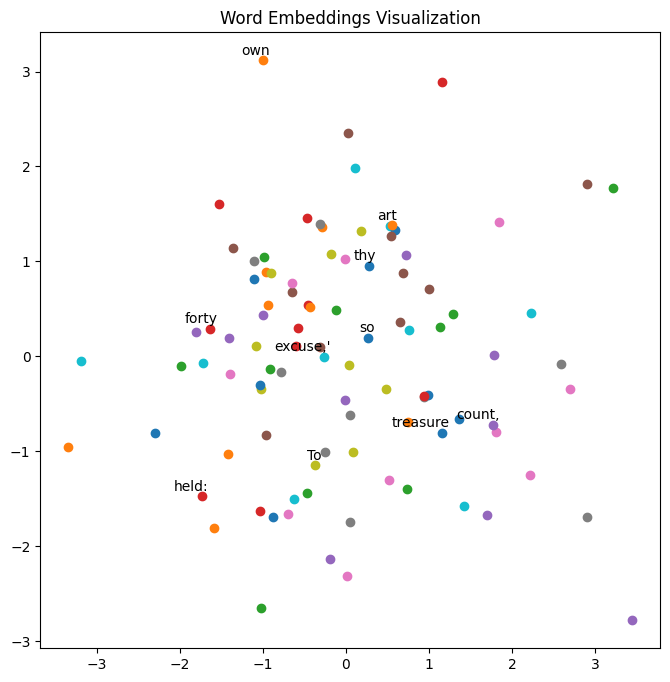

In [14]:
plot_embeddings(model, vocab)

### CBOW

In [15]:
idx_to_word = {idx: word for idx, word in enumerate(vocab)}


In [16]:
CONTEXT_SIZE = 2  # CONTEXT_SIZE words to the left, CONTEXT_SIZE to the right

splitted_text = splitted_text[:7]

data = []
for i in range(CONTEXT_SIZE, len(splitted_text) - CONTEXT_SIZE):
    context = []
    context.extend([splitted_text[j] for j in range(i - CONTEXT_SIZE, i)])
    context.extend([splitted_text[j] for j in range(i + 1, i + CONTEXT_SIZE + 1)])
    target = splitted_text[i]
    data.append((context, target))

In [17]:
def make_context_vector(context: list[str]) -> list[int]:
    return torch.tensor([word_to_idx[w] for w in context], dtype=torch.long)

In [18]:
class CBOW(torch.nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int) -> None:
        super(CBOW, self).__init__()

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)
        

    def forward(self, inputs: torch.tensor) -> torch.tensor:
        embeds = sum(self.embeddings(inputs)).view(1,-1)
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        out = F.log_softmax(out, dim=-1)
        return out

    def get_word_embedding(self, word: str) -> torch.tensor:
        word = torch.tensor([word_to_idx[word]])
        return self.embeddings(word).squeeze()

In [19]:
EMDEDDING_DIM = 100

model = CBOW(len(vocab), EMDEDDING_DIM)

In [20]:
LEARNING_RATE = 0.001
EPOCHS = 50

losses: list[float] = []
loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [21]:
for epoch in range(EPOCHS):
    total_loss = 0

    for context, target in data:
        context_vector = make_context_vector(context)  

        model.zero_grad()

        log_probs = model(context_vector)

        loss = loss_function(log_probs, torch.tensor([word_to_idx[target]]))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    losses.append(total_loss)

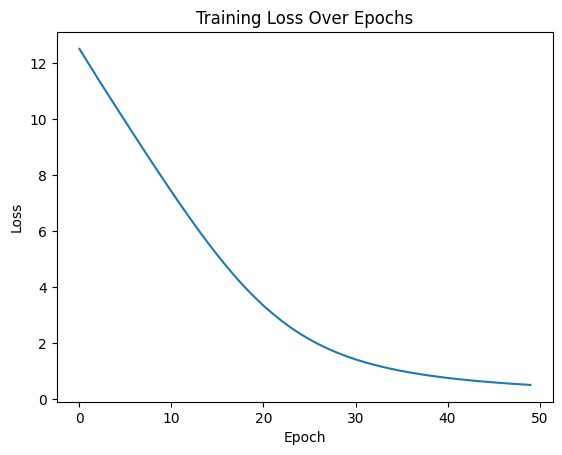

In [22]:
plt.plot(losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [23]:
compare_word_embeddings(model, ["beauty", "warm", "cold."])

Cosine similarity of 'beauty' and 'warm': -0.10904916375875473
Cosine similarity of 'beauty' and 'cold.': 0.03119681030511856
Cosine similarity of 'warm' and 'cold.': 0.02782709151506424


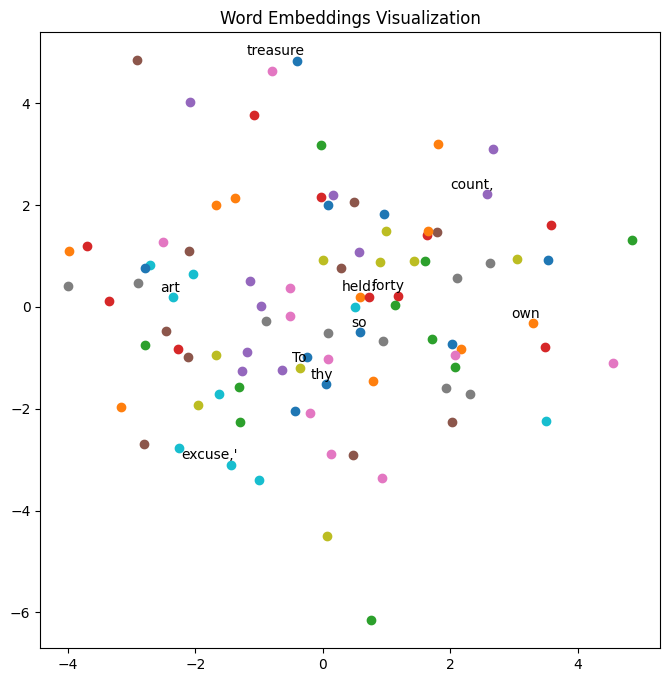

In [24]:
plot_embeddings(model, vocab)

### Curse of Dimensionality
#### Density of Hypercubes

The volume of a $d$-dimensional hypercube is $V_C(a)=a^d$ where $a$ is the side length of the cube. The volumen of a $d$-dimensional ball is
$$
    V_S(r) = \frac{r^d\pi^{d/2}}{\Gamma(\frac{d}{2} + 1)}.
$$

Therefore, the percentage of space of a unit hypercube which can be filled by the biggest inscribed hyperball is
$$
    \frac{V_S(\frac{1}{2})}{V_C(1)} = \frac{(\frac{1}{2})^d\pi^{d/2}}{\Gamma(\frac{d}{2} + 1)} = \frac{(\frac{1}{4})^{d/2}\pi^{d/2}}{\Gamma(\frac{d}{2} + 1)} = \frac{\left(\frac{\pi}{4}\right)^{d/2}}{\Gamma(\frac{d}{2} + 1)} \overset{d\to\infty}{\longrightarrow} 0
$$
because the numerator converges to $0$ and the denominator diverges to $\infty$.

In particular, we can see for the first dimensions the following ratios:

ADD TABLE

Therefore, we see that the volumen of a cube is not in the center, but in the edges. Another way to think about this is that the distance between an edge and the center is $\sqrt{d}/2$, which is strictly increasing while all points on the sphere have distance $1$ to the center.

#### Number of points

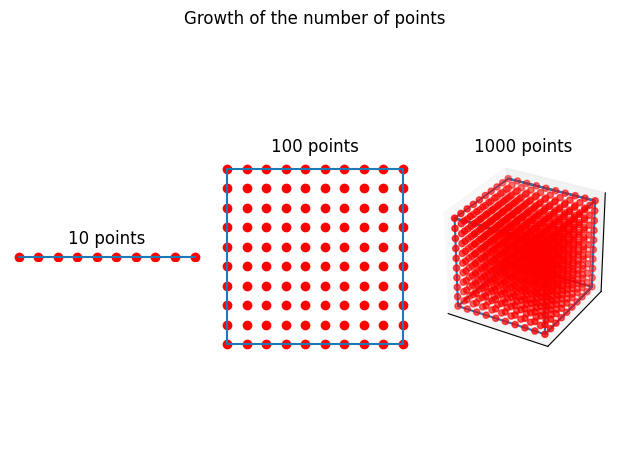

In [25]:
def plot_unit_interval(ax, num_points: int, step_size: float) -> None:
    unit_interval = [0, 1]

    x_coords = [i * step_size for i in range(num_points)]

    y_coord = 0.5

    ax.plot(unit_interval, [y_coord, y_coord])
    ax.scatter(x_coords, [y_coord] * num_points, color='red')
    ax.set_axis_off()
    ax.set_aspect("equal")
    ax.set_title("10 points")

def plot_unit_square(ax, num_points: int, step_size: float) -> None:
    square_coords = [(0, 0), (1, 0), (1, 1), (0, 1), (0, 0)]
    ax.plot([x[0] for x in square_coords], [x[1] for x in square_coords])

    side_length = 1

    grid_coords = [(i * step_size, j * step_size) for i in range(num_points) for j in range(num_points)]

    ax.scatter([x[0] for x in grid_coords], [x[1] for x in grid_coords], color='red')

    ax.set_aspect("equal")
    ax.set_axis_off()
    ax.set_title("100 points")

def plot_unit_cube(ax, num_points: int, step_size: float) -> None:
    ax.set_axis_off()
    ax = fig.add_subplot(1, 3, 3, projection='3d')

    # Define the cube vertices
    cube_coords = np.array([[0, 0, 0],
                            [1, 0, 0],
                            [1, 1, 0],
                            [0, 1, 0],
                            [0, 0, 0],
                            [0, 0, 1],
                            [1, 0, 1],
                            [1, 1, 1],
                            [0, 1, 1],
                            [0, 0, 1],
                            [1, 0, 1],
                            [1, 0, 0],
                            [1, 1, 0],
                            [1, 1, 1],
                            [0, 1, 1]])

    ax.plot(cube_coords[:, 0], cube_coords[:, 1], cube_coords[:, 2])

    grid_coords = np.array([[i * step_size, j * step_size, k * step_size]
                            for i in range(num_points)
                            for j in range(num_points)
                            for k in range(num_points)])

    ax.scatter(grid_coords[:, 0], grid_coords[:, 1], grid_coords[:, 2], color='red')
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_title("1000 points")

fig, axes = plt.subplots(ncols=3)

num_points = 10

step_size = 1 / 9
plot_unit_interval(axes[0], num_points, step_size)
plot_unit_square(axes[1], num_points, step_size)
plot_unit_cube(axes[2], num_points, step_size)

plt.suptitle("Growth of the number of points")
plt.tight_layout()
plt.show()

#### Average Angle

In [26]:
def generate_random_unit_vector(d: int) -> np.array:
    vec = np.random.randn(d)
    vec /= np.linalg.norm(vec)
    return vec

In [27]:
def get_angles(d: int, num_points: int = 100) -> list[float]:
    angles: list[float] = []
    points = [generate_random_unit_vector(d) for _ in range(num_points)]
    pairs = list(combinations(points, 2))

    for (p1, p2) in pairs:
        angles.append(np.dot(p1, p2))

    return angles

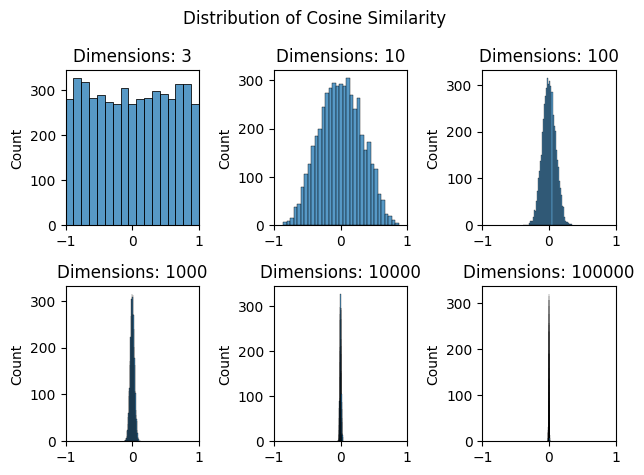

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=3)

dimensions = [3, 10, 100, 1000, 10000, 100000]

for index, d in enumerate(dimensions):
    i = index // 3
    j = index % 3

    sns.histplot(get_angles(d), ax=axes[i][j])
    axes[i][j].set_xlim(-1, 1)
    axes[i][j].set_title(f"Dimensions: {d}")

plt.suptitle("Distribution of Cosine Similarity")
plt.tight_layout()
plt.show()

#### Average Distance

In [29]:
def get_relative_distances(d: int, num_points: int = 300) -> np.array:
    distances: list[float] = []

    points = np.random.rand(num_points, d)

    pairs = list(combinations(points, 2))

    for (p1, p2) in pairs:
        distance = np.linalg.norm(p1 - p2)
        distances.append(distance / np.sqrt(d))

    return distances

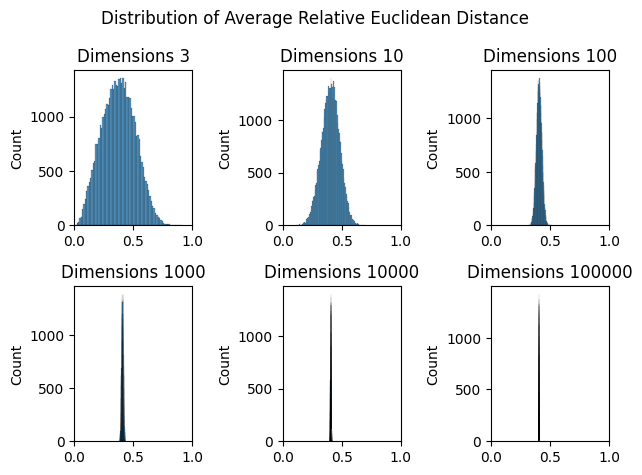

In [30]:
dimensions = [3, 10, 100, 1000, 10000, 100000]

fig, axes = plt.subplots(nrows=2, ncols=3)

for index, d in enumerate(dimensions):
    i = index // 3
    j = index % 3

    sns.histplot(get_relative_distances(d), ax=axes[i][j])
    axes[i][j].set_title(f"Dimensions {d}")
    axes[i][j].set_xlim(0, 1)

plt.suptitle("Distribution of Average Relative Euclidean Distance")
plt.tight_layout()
plt.show()